In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
pd.set_option('display.max_colwidth', None)
from statsmodels.iolib.summary2 import summary_col 
import seaborn as sns

import warnings
# Ignore warnings by category
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Ignore warnings by message
warnings.filterwarnings("ignore", message=".*")

In [2]:
bank_tract = pd.read_csv("../input_data_clean/bank_tract_clean_WITH_CENSUS.csv")
bank_tract['which_bank'] = bank_tract['which_bank'].str.replace(' ', '')

In [3]:
bank_tract['which_bank'].value_counts()

AllOtherBanks    9337
BankofWest       4500
Name: which_bank, dtype: int64

In [4]:
# Calculate the hispanic rate and whether it's above the median
bank_tract['hisp_rate'] = (bank_tract['HispanicLatinoPop'] / bank_tract['Tot.Pop']) * 100
bank_tract['hisp_over_med'] = bank_tract['hisp_rate'] > np.median(bank_tract['hisp_rate'].dropna())
bank_tract['hisp_over_med'] = bank_tract['hisp_over_med'].astype(int)

# Adding them at the start so that they don't get set to 0
bank_tract.insert(0, 'hisp_over_med', bank_tract.pop('hisp_over_med'))
bank_tract.insert(0, 'hisp_rate', bank_tract.pop('hisp_rate'))

# Calculate the black rate and whether it's above the median
bank_tract['black_rate'] = (bank_tract['Tot.BlackPop '] / bank_tract['Tot.Pop']) * 100
bank_tract['black_over_med'] = bank_tract['black_rate'] > np.median(bank_tract['black_rate'].dropna())
bank_tract['black_over_med'] = bank_tract['black_over_med'].astype(int)

# Adding them at the start so that they don't get set to 0
bank_tract.insert(0, 'black_over_med', bank_tract.pop('black_over_med'))
bank_tract.insert(0, 'black_rate', bank_tract.pop('black_rate'))

# Calculate the asian rate and whether it's above the median
bank_tract['asian_rate'] = (bank_tract['Tot.AsianPop'] / bank_tract['Tot.Pop']) * 100
bank_tract['asian_over_med'] = bank_tract['asian_rate'] > np.median(bank_tract['asian_rate'].dropna())
bank_tract['asian_over_med'] = bank_tract['asian_over_med'].astype(int)

# Adding them at the start so that they don't get set to 0
bank_tract.insert(0, 'asian_over_med', bank_tract.pop('asian_over_med'))
bank_tract.insert(0, 'asian_rate', bank_tract.pop('asian_rate'))

#White rate var
bank_tract['white_rate'] = (bank_tract['Tot.WhitePop'] / bank_tract['Tot.Pop']) * 100
bank_tract.insert(0, 'white_rate', bank_tract.pop('white_rate'))

# Creating the major minority variable
#bank_tract['major_minority'] = bank_tract.apply(lambda row: 'Hispanic' if row['hisp_rate'] > row['black_rate'] and row['hisp_rate'] > row['asian_rate'] else ('Asian' if row['asian_rate'] > row['black_rate'] and row['asian_rate'] > row['hisp_rate'] else 'Black'), axis=1)
#bank_tract.insert(0, 'major_minority', bank_tract.pop('major_minority'))

bank_tract["major_minority"] = bank_tract['white_rate'] < 0.5
bank_tract["major_minority"] = bank_tract["major_minority"].astype(int)
bank_tract.insert(0, 'major_minority', bank_tract.pop('major_minority'))


# Calculate the log of number of applications
bank_tract['log_num_apps'] = np.log(1+bank_tract['num_applications'])

### Adding rows (census tracts) where BoW is not active, but All Other Banks Are 

In [5]:
# Create a copy of the original dataframe
bank_tract_new = bank_tract.copy()

# Find the census tracts that have AllOtherBanks but not BankofWest
missing_tracts = bank_tract_new[(bank_tract_new['which_bank'] == 'AllOtherBanks') & ~(bank_tract_new['census_tract'].isin(bank_tract_new[bank_tract_new['which_bank'] == 'BankofWest']['census_tract']))]

# Update which_bank column to BankofWest
missing_tracts['which_bank'] = 'BankofWest'

# Set bank specific variables to 0
start_col = bank_tract.columns.get_loc('sum_approved_loans')
bank_specific_vars = bank_tract.columns[start_col:]
missing_tracts[bank_specific_vars] = np.NaN
missing_tracts['log_num_apps'] = 0

# Append the missing rows to the new dataframe
bank_tract_new = pd.concat([bank_tract_new, missing_tracts], ignore_index=True)

# Verify that there are now equal numbers of rows for each which_bank value
bank_tract_new["which_bank"].value_counts()

BankofWest       9340
AllOtherBanks    9337
Name: which_bank, dtype: int64

### Adding rows (census tracts) where All Other Banks Are are not active, but BoW is.

In [6]:
# Create a copy of the original dataframe
bank_tract_full = bank_tract_new.copy()

# Find the census tracts that have BankofWest but not AllOtherBanks
missing_tracts1 = bank_tract_full[(bank_tract_full['which_bank'] == 'BankofWest') & ~(bank_tract_full['census_tract'].isin(bank_tract_full[bank_tract_full['which_bank'] == 'AllOtherBanks']['census_tract']))]

# Update which_bank column to AllOtherBanks
missing_tracts1['which_bank'] = 'AllOtherBanks'

# Set bank specific variables to NaN
start_col1 = bank_tract.columns.get_loc('sum_approved_loans')
bank_specific_vars1 = bank_tract.columns[start_col:]
missing_tracts1[bank_specific_vars1] = np.NaN
missing_tracts1['log_num_apps'] = 0

# Append the missing rows to the new dataframe
bank_tract_full = pd.concat([bank_tract_full, missing_tracts1], ignore_index=True)

# Verify that there are now equal numbers of rows for each which_bank value
bank_tract_full["which_bank"].value_counts()

AllOtherBanks    9340
BankofWest       9340
Name: which_bank, dtype: int64

In [7]:
# Creating a denial count variabel so that in th eregression models only rows that have a non-null denial rate are included 
bank_tract_full['tract_denial_count'] = bank_tract_full.groupby('census_tract')['denial_rate'].transform(pd.Series.count)

### Investigating more control variables to include in regression

In [8]:
#census_vars = pd.read_csv("../input_data/census_vars.csv")

#possible_vars = census_vars.iloc[:88, 1]

#pd.set_option("display.max_rows", None)

#possible_vars

Vars to use: Median household Income, Ratio of Income to Poverty Level, Per Capita Incoome, Median Family Income

### Cleaning census control vars to use in regression

In [8]:
# List of variables to clean
cols_to_clean = ["Med.HousehIncome", "RatioIncomeToPovertyLevel", "PerCap.Income", "Med.FamIncome","Pop0_0.49PovLevel","Pop0.5_0.99PovLevel"]

# Replace empty and negative values with NaN
bank_tract_full[cols_to_clean] = bank_tract_full[cols_to_clean].applymap(lambda x: np.NaN if (x == '' or x < 0) else x)

In [9]:
# Possible columns to include
cols_to_clean.extend(['median_all_income', "mean_LTV"])
bank_tract_full[cols_to_clean].describe()

,Med.HousehIncome,RatioIncomeToPovertyLevel,PerCap.Income,Med.FamIncome,Pop0_0.49PovLevel,Pop0.5_0.99PovLevel,median_all_income,mean_LTV
count,18658.000000,18680.000000,18674.000000,18614.000000,18680.000000,18680.000000,13435.000000,13833.000000
mean,79065.168400,4818.880621,37180.969262,90385.196949,288.648929,361.142505,153.556085,63.655351
std,38400.119425,2169.322939,21572.777062,45020.093275,279.379369,341.454320,327.767463,19.763747
min,11576.000000,0.000000,1276.000000,14471.000000,0.000000,0.000000,0.000000,2.884700
25%,50802.000000,3416.000000,22047.000000,56482.750000,110.000000,116.000000,84.000000,55.788607
50%,71000.000000,4534.500000,31681.000000,80332.000000,207.000000,254.500000,114.000000,64.124411
75%,98375.000000,5848.000000,45846.000000,114209.500000,375.000000,503.000000,170.000000,72.347100
max,250001.000000,30844.000000,176388.000000,250001.000000,4401.000000,3404.000000,33827.000000,1815.708527


In [10]:
# populate null values with 0
bank_tract_full["hisp_rate"].fillna(0, inplace=True)
bank_tract_full["black_rate"].fillna(0, inplace=True)
bank_tract_full["asian_rate"].fillna(0, inplace=True)
bank_tract_full["white_rate"].fillna(0, inplace=True)

#Change the name of the Med.HousehIncome variable
bank_tract_full.rename(columns={"Med.HousehIncome":"MedHousehIncome", "PerCap.Income" : "PerCapIncome", "Med.FamIncome":"MedFamIncome"}, inplace=True)

In [11]:
bank_tract_full[['log_num_apps','hisp_rate','hisp_over_med',"black_rate", "black_over_med","asian_rate", "asian_over_med", "white_rate", "major_minority", 'which_bank','median_all_income','mean_LTV']].count()

log_num_apps         18680
hisp_rate            18680
hisp_over_med        18680
black_rate           18680
black_over_med       18680
asian_rate           18680
asian_over_med       18680
white_rate           18680
major_minority       18680
which_bank           18680
median_all_income    13435
mean_LTV             13833
dtype: int64

<AxesSubplot: >

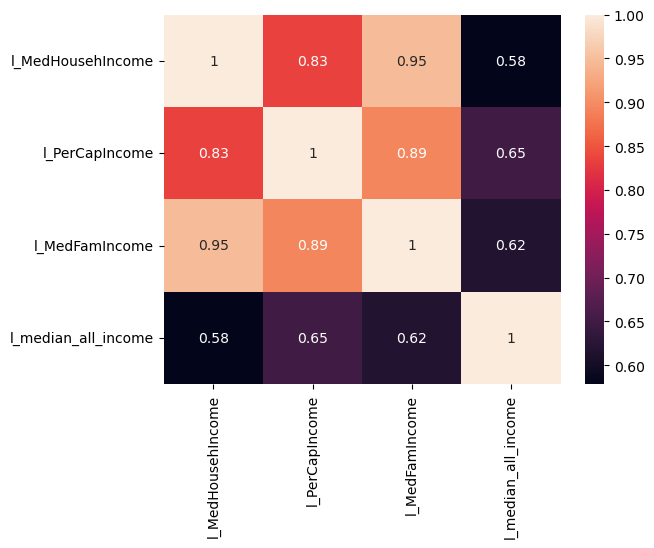

In [20]:
# Logging census control vars
bank_tract_full["l_MedHousehIncome"] = np.log(1+bank_tract_full["MedHousehIncome"])
bank_tract_full["l_PerCapIncome"] = np.log(1+bank_tract_full["PerCapIncome"])
bank_tract_full["l_MedFamIncome"] = np.log(1+bank_tract_full["MedFamIncome"])
bank_tract_full["l_median_all_income"] = np.log(1+bank_tract_full["median_all_income"])
bank_tract_full["l_mean_approved_rate_spread"] = np.log(1+bank_tract_full["mean_approved_rate_spread"])

cols = ["l_MedHousehIncome", "l_PerCapIncome", "l_MedFamIncome", "l_median_all_income"]

# Compute the correlation matrix
corr_matrix = bank_tract_full[cols].corr()
sns.heatmap(corr_matrix, annot = True)

They are all highly correlated so just use one of them

In [21]:
# Create new income variable
bank_tract_full["poverty_ratio"] = (bank_tract_full["Pop0_0.49PovLevel"] +  bank_tract_full["Pop0.5_0.99PovLevel"]) / bank_tract_full["RatioIncomeToPovertyLevel"]
bank_tract_full["bank_gets_highinc_subpop"] = bank_tract_full["median_all_income"] > bank_tract_full["MedHousehIncome"]

In [22]:
bank_tract_full["bank_gets_highinc_subpop"].value_counts()

False    18680
Name: bank_gets_highinc_subpop, dtype: int64

In [23]:
def winsorizer_with_missing(df,low_=.01,hi_=.99,cols=None): 
    '''
    Parameters
    ----------
    df : DATAFRAME
    low_ : float, optional (default = 0.01)
        What to winsorize the left tail of each variable to.
    hi_ : float, optional (default = 0.99)
        What to winsorize the right tail of each variable to.
        Set to 0.95 for 5% winsorizing, or .99 for 1% winsorizing.
    cols : list, required
        What columns to winsorize

    Returns
    -------
    df, with columns altered by winsorizing. 
    
    Description
    -------    
    Winsorize columns of a dataframe. It ignores missing values, which 
    is usually what you want. 
        
    TIP: Put this function in your codebook to reuse easily.

    TIP/WARNING: This is a new function and hasn't been subject to much scrutiny.
    So check its work! After using it, summarize the variables you wanted to 
    winsorize and see that the max and min equal the right percentiles!

    EXTRA CREDIT: (1) Use this function such that it performs winsorization within
    groups or (2) change this function so it optionally takes an argument that specify
    groups to do the winsorizing within. 

    Warning/option for extra credit: There is NO error checking in this function.
    (For example: What happens if you set low_ = -1, or low_=1.1? What "should" this
    function do if a user sets those values?)
    
    CURIOUSITY/EXTRA CREDIT: How does this function deal with ties? Check by using 
    tiny dataframe (20 rows max, but with ties just below, right at, and just above
    the cutoffs). 
    
    '''
    if not cols: # if no cols provides, stop, and force an error in the code
        print("You didn't tell me what columns to winsorize!")
        errrrorororororororor # this will cause a break (this is not good coding practice, but works, lolz)
        
    df[cols] = df[cols].clip(lower=df[cols].quantile(low_),
                             upper=df[cols].quantile(hi_),
                             axis=1)
    return df

In [24]:
# Windsorizing mean_LTV control variable
bank_tract_full = winsorizer_with_missing(bank_tract_full, low_=.01,hi_=.95,cols=["mean_LTV"])

In [25]:
census_tract_vars = ["l_MedHousehIncome", "poverty_ratio"]
bank_tract_vars = ["mean_LTV",'bank_gets_highinc_subpop']

### Denial Rate Regression table using minority over median variables

In [26]:
x_vars = ['hisp_over_med','black_over_med','asian_over_med',"major_minority"]

# instead of having a row for each minority vairable, combine into one row, column labels will distinguish
# create custom variable labels for the variables you want to combine
varlabels = {v:'High Minority' for v in x_vars}

results = []
for v in x_vars :
    formula = f"denial_rate ~ Q('High Minority') * which_bank + {'+'.join(census_tract_vars)} + {'+'.join(bank_tract_vars)}"
    #print(formula)
    results.append(
        smf.ols(formula,
                data=bank_tract_full.query("tract_denial_count == 2").rename(columns={v:varlabels[v]})
               ).fit()
    )

# now I'll format an output table
# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

print('='*110)
print('                                             y = denial_rate')

# This summary col function combines a bunch of regressions into one nice table
print(summary_col(results=results, 
                  float_format='%0.4f',
                  stars = True, 
                  model_names=["Hispanic", "Black", "Asian", "MajorityMinority"],
                  info_dict=info_dict,
                  regressor_order=[ 'Intercept', "which_bank[T.BankofWest]", "Q('High Minority')", "Q('High Minority'):which_bank[T.BankofWest]",
                                 "l_MedHousehIncome", "poverty_ratio", "mean_LTV", "bank_gets_highinc_subpop[T.True]"]
                  )
     )

                                             y = denial_rate

                                             Hispanic    Black      Asian    MajorityMinority
---------------------------------------------------------------------------------------------
Intercept                                   0.0852     0.1285     0.1886**   0.1338          
                                            (0.0867)   (0.0834)   (0.0849)   (0.0831)        
which_bank[T.BankofWest]                    0.0876***  0.0704***  0.0019     0.0497***       
                                            (0.0049)   (0.0051)   (0.0057)   (0.0037)        
Q('High Minority')                          0.0543***  0.0222***  -0.0403*** -0.0000*        
                                            (0.0058)   (0.0054)   (0.0055)   (0.0000)        
Q('High Minority'):which_bank[T.BankofWest] -0.0879*** -0.0441*** 0.0839***  0.0000          
                                            (0.0075)   (0.0075)   (0.0075)   (0.0000)       

### Rate Spread Regression table using minority over median variables

In [31]:
x_vars = ['hisp_over_med','black_over_med','asian_over_med',"major_minority"]

# instead of having a row for each minority vairable, combine into one row, column labels will distinguish
# create custom variable labels for the variables you want to combine
varlabels = {v:'High Minority' for v in x_vars}

results = []
for v in x_vars :
    formula = f"mean_approved_rate_spread ~ Q('High Minority') * which_bank + {'+'.join(census_tract_vars)} + {'+'.join(bank_tract_vars)}"
    #print(formula)
    results.append(
        smf.ols(formula,
                data=bank_tract_full.query("tract_denial_count == 2").rename(columns={v:varlabels[v]})
               ).fit()
    )

# now I'll format an output table
# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

print('='*110)
print('                                             y = mean_approved_rate_spread')

# This summary col function combines a bunch of regressions into one nice table
print(summary_col(results=results, 
                  float_format='%0.4f',
                  stars = True, 
                  model_names=["Hispanic", "Black", "Asian", "MajorityMinority"],
                  info_dict=info_dict,
                  regressor_order=[ 'Intercept', "which_bank[T.BankofWest]", "Q('High Minority')", "Q('High Minority'):which_bank[T.BankofWest]",
                                 "l_MedHousehIncome", "poverty_ratio", "mean_LTV", "bank_gets_highinc_subpop[T.True]"]
                  )
     )

                                             y = mean_approved_rate_spread

                                             Hispanic    Black      Asian    MajorityMinority
---------------------------------------------------------------------------------------------
Intercept                                   2.6661***  3.0669***  3.0769***  3.1145***       
                                            (0.1976)   (0.1895)   (0.1940)   (0.1886)        
which_bank[T.BankofWest]                    0.2051***  0.2339***  0.2627***  0.2409***       
                                            (0.0111)   (0.0116)   (0.0134)   (0.0086)        
Q('High Minority')                          0.0279**   0.0151     0.0143     -0.0000***      
                                            (0.0130)   (0.0119)   (0.0124)   (0.0000)        
Q('High Minority'):which_bank[T.BankofWest] 0.0876***  0.0157     -0.0368**  0.0000          
                                            (0.0175)   (0.0172)   (0.0175)   (

### Log number apps regression table using minority over median variables

In [28]:
x_vars = ['hisp_over_med','black_over_med','asian_over_med',"major_minority"]

# instead of having a row for each minority vairable, combine into one row, column labels will distinguish
# create custom variable labels for the variables you want to combine
varlabels = {v:'High Minority' for v in x_vars}

results = []
for v in x_vars :
    formula = f"log_num_apps ~ Q('High Minority') * which_bank + {'+'.join(census_tract_vars)}"
    #print(formula)
    results.append(
        smf.ols(formula,
                data=bank_tract_full.rename(columns={v:varlabels[v]})
               ).fit()
    )

# now I'll format an output table
# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

print('='*110)
print('                                             y = log_num_apps')

# This summary col function combines a bunch of regressions into one nice table
print(summary_col(results=results, 
                  float_format='%0.4f',
                  stars = True, 
                  model_names=["Hispanic", "Black", "Asian", "MajorityMinority"],
                  info_dict=info_dict,
                  regressor_order=[ 'Intercept', "which_bank[T.BankofWest]", "Q('High Minority')", "Q('High Minority'):which_bank[T.BankofWest]",
                                 "l_MedHousehIncome", "poverty_ratio", "mean_LTV", "bank_gets_highinc_subpop[T.True]"]
                  )
     )

                                             y = log_num_apps

                                             Hispanic    Black      Asian    MajorityMinority
---------------------------------------------------------------------------------------------
Intercept                                   -3.5552*** -3.9933*** -4.2042*** -3.9208***      
                                            (0.2214)   (0.2125)   (0.2198)   (0.2117)        
which_bank[T.BankofWest]                    -3.3040*** -3.2005*** -3.3553*** -3.2589***      
                                            (0.0147)   (0.0144)   (0.0137)   (0.0101)        
Q('High Minority')                          -0.1023*** 0.0792***  -0.1618*** 0.0000***       
                                            (0.0152)   (0.0144)   (0.0148)   (0.0000)        
Q('High Minority'):which_bank[T.BankofWest] 0.0847***  -0.1136*** 0.2065***  0.0000          
                                            (0.0201)   (0.0201)   (0.0201)   (0.0000)      

## Receives any apps regression table

In [22]:
bank_tract_full['some_apps'] = 1*(bank_tract_full['log_num_apps'] > 0)

In [23]:
x_vars = ['hisp_over_med','black_over_med','asian_over_med',"major_minority"]

# instead of having a row for each minority vairable, combine into one row, column labels will distinguish
# create custom variable labels for the variables you want to combine
varlabels = {v:'High Minority' for v in x_vars}

results = []
for v in x_vars :
    formula = f"some_apps ~ Q('High Minority') * which_bank + {'+'.join(census_tract_vars)}"
    #print(formula)
    results.append(
        smf.ols(formula,
                data=bank_tract_full.rename(columns={v:varlabels[v]})
               ).fit()
    )

# now I'll format an output table
# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

print('='*110)
print('                                             y = Receives any apps in the tract')

# This summary col function combines a bunch of regressions into one nice table
print(summary_col(results=results, 
                  float_format='%0.4f',
                  stars = True, 
                  model_names=["Hispanic", "Black", "Asian", "MajorityMinority"],
                  info_dict=info_dict,
                  regressor_order=[ 'Intercept', "High Minority", "which_bank[T.BankofWest]", "High Minority:which_bank[T.BankofWest]",
                                 "MedHousehIncome", "PerCapIncome", "MedFamIncome", "median_all_income", "mean_LTV"]
                  )
     )

                                             y = Receives any apps in the tract

                                             Hispanic    Black      Asian    MajorityMinority
---------------------------------------------------------------------------------------------
Intercept                                   -1.4261*** -1.4367*** -1.1854*** -1.4274***      
                                            (0.1089)   (0.1054)   (0.1082)   (0.1051)        
which_bank[T.BankofWest]                    -0.4152*** -0.4749*** -0.6096*** -0.5174***      
                                            (0.0072)   (0.0071)   (0.0068)   (0.0050)        
Q('High Minority')                          0.0869***  0.0352***  -0.0641*** 0.0000***       
                                            (0.0075)   (0.0071)   (0.0073)   (0.0000)        
Q('High Minority'):which_bank[T.BankofWest] -0.1920*** -0.0828*** 0.1974***  0.0000          
                                            (0.0099)   (0.0100)   (0.0099